# Lab Session 1: Web Browsing Traces & Digital Fingerprinting

## Introduction
The topic of this session is **Digital Traces and Human Behavior**. We will provide a dataset of individuals' web browsing traces combined with their sociodemographic information collected via surveys.

In this session, we will focus on **data cleaning, feature generation, and visualization**. We will analyze the data to examine the patterns of individuals' internet use and how they vary across different demographic groups. Participants will also have the opportunity to analyze their own browsing history to infer some of these associations for themselves.

### Learning Objectives:
* Perform data cleaning on raw web logs to remove noise and bots.
* Extract temporal and content-based features from URLs and timestamps.
* Generate advanced behavioral visualizations (Heatmaps, Bubble Charts, Word Clouds).
* Analyze digital traces across different demographic groups.


In [1]:
# Install specialized libraries
!pip install circlify wordcloud stop-words

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import circlify
import re
import os
import warnings
from collections import Counter
from wordcloud import WordCloud
from stop_words import get_stop_words
from urllib.parse import unquote

warnings.filterwarnings('ignore')

# Plotting configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline


### Programming Toolkit
To perform this analysis, we will use several specialized Python libraries. You can refer to the official documentation for detailed API information:

| Library | Category | Purpose | Documentation |
| :--- | :--- | :--- | :--- |
| **Pandas** | Data Processing | Data manipulation and DataFrame operations | [Docs](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) |
| **NumPy** | Mathematics | Numerical computing and array operations | [Docs](https://numpy.org/doc/stable/user/index.html#user) |
| **Matplotlib** | Visualization | Core library for static plots | [Docs](https://matplotlib.org/stable/contents.html) |
| **Seaborn** | Visualization | Statistical data visualization | [Docs](https://seaborn.pydata.org/tutorial/introduction.html) |
| **WordCloud** | NLP/Visualization | Generating tag clouds from text | [Docs](https://amueller.github.io/word_cloud/) |
| **Circlify** | Visualization | Circle packing for bubble charts | [GitHub](https://github.com/elmotec/circlify) |
| **Stop-Words** | NLP | Filtering common words in multiple languages | [PyPI](https://pypi.org/project/stop-words/) |

In [6]:

BASE_URL = "https://raw.githubusercontent.com/Yajing-W/CSS_winterschool_practice/refs/heads/main/"

df = pd.read_csv(BASE_URL + "browsing_traces.csv")
demo_df = pd.read_csv(BASE_URL + "demographics.csv")
category_df = pd.read_csv(BASE_URL + "domain_category_map.csv")
print("Datasets loaded successfully.")

print(f"Browsing traces: {df.shape}")
print(f"Demographics: {demo_df.shape}")
print(f"Domain_category_map: {category_df.shape}")

df.head(3)

Datasets loaded successfully.
Browsing traces: (114809, 5)
Demographics: (13, 3)
Domain_category_map: (3690, 2)


,pid,used_at,url,duration,domain
0,17928016490048,2023-06-25 22:32:40,duckduckgo.com/2072190,1.0,duckduckgo.com
1,17928016490048,2023-06-25 22:32:42,duckduckgo.com/2072191,8.0,duckduckgo.com
2,17928016490048,2023-06-25 22:32:51,my.bbf.be/5351762,3.0,bbf.be


## Part 1: Data Cleaning (Valid Signal Identification)

Raw browsing logs often contain noise such as background ads, automatic refreshes, or idle sessions. Before profiling users, we must ensure the data represents genuine human intent and active engagement.

> **💡 Coding Tip:**
> * When converting time, use `pd.to_datetime(..., utc=True)` to handle potential timezone issues efficiently.
> * **Logic Filtering**: In real-world datasets, a "zero duration" is often a tracking error or a failed page load.

#### 📝 Task 1: Basic Cleaning & Anomaly Detection
1. **Time Conversion**: Convert the `used_at` column to Pandas `datetime` objects.
2. **Standard Filter**: Remove records where `duration` is 0 or missing.
3. **Ghost Session Identification**: Identify "Ghost Sessions" where `duration` exceeds 4 hours (14,400s). These are typically caused by tabs left open overnight or background processes (e.g., music/gaming).
4. **Data Comparison**: Observe how these "Ghost Sessions" distort the overall statistics.

Standard Cleaning: Removed 6712 invalid records.
Ghost Detection: Found 18936 sessions > 4 hours.
Impact: These few sessions account for 99.86% of total recorded time!


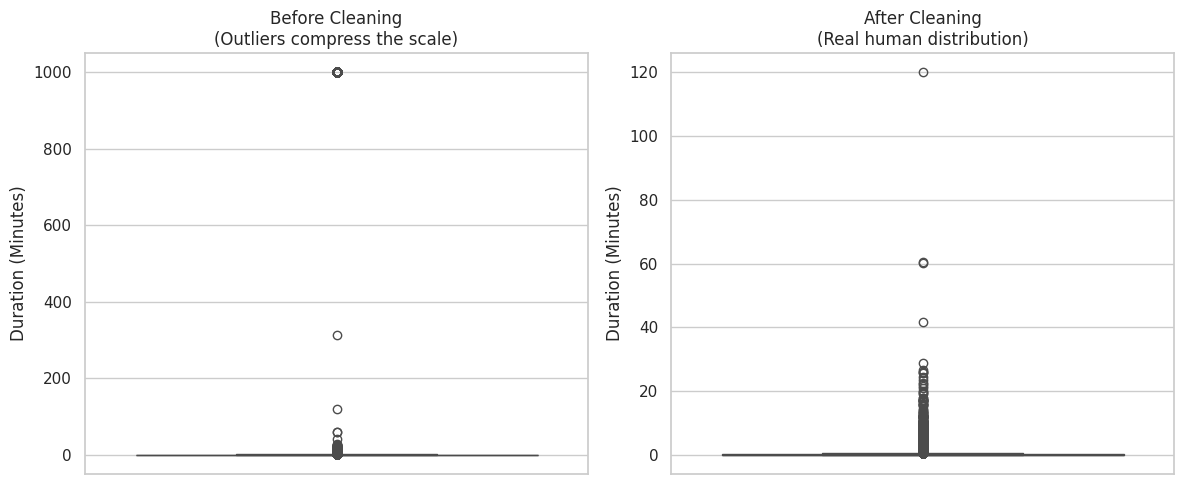

In [7]:
# 1. Standard Cleaning
# Convert to datetime and ensure UTC consistency
df['used_at'] = pd.to_datetime(df['used_at'], utc=True)

# Remove zero/null durations
initial_count = len(df)
df = df[df['duration'] > 0].dropna(subset=['duration'])
print(f"Standard Cleaning: Removed {initial_count - len(df)} invalid records.")

# 2. Anomaly Detection (Ghost Sessions)
# Define threshold: 4 hours = 14400 seconds
GHOST_THRESHOLD = 14400
df['is_ghost'] = df['duration'] > GHOST_THRESHOLD

ghost_count = df['is_ghost'].sum()
ghost_time_share = df[df['is_ghost']]['duration'].sum() / df['duration'].sum()

print(f"Ghost Detection: Found {ghost_count} sessions > 4 hours.")
print(f"Impact: These few sessions account for {ghost_time_share:.2%} of total recorded time!")

# Create a cleaned dataset for behavior analysis
df_final = df[df['is_ghost'] == False].copy()

# 3. Visualization: Why we clean outliers
plt.figure(figsize=(12, 5))

# Plot: Boxplot comparison
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y=df['duration'] / 60)
plt.title("Before Cleaning\n(Outliers compress the scale)")
plt.ylabel("Duration (Minutes)")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_final, y=df_final['duration'] / 60)
plt.title("After Cleaning\n(Real human distribution)")
plt.ylabel("Duration (Minutes)")

plt.tight_layout()
plt.show()

## Part 1.2: Behavioral Profiling & Visualization (EDA)

With the noise removed, we can now answer: **"Who are our users, and how do they engage with the platform?"** We will use three classic visualization methods to understand the population.

#### 📝 Task 1.2: Quantifying User Engagement
1. **Persistence (Active Days)**: How many unique days did each user (`pid`) appear during the month?
2. **Intensity (Daily Usage)**: On the days they were active, how many hours did they spend browsing on average?
3. **Distribution Analysis**:
    * Use a **Histogram** to see the spread of active days.
    * Use a **CDF (Cumulative Distribution Function)** to identify the "Heavy Users" threshold.

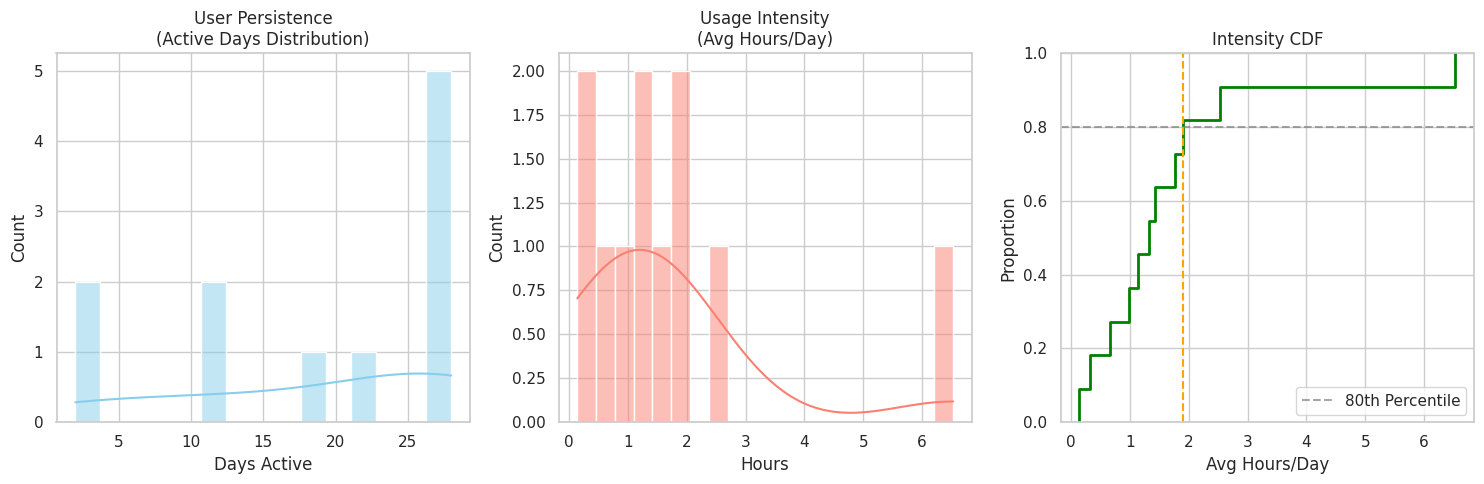

Summary Statistics:
- Average Active Days: 19.0 days
- Median Daily Usage: 1.33 hours
- 80% of users spend less than 1.90 hours per day.


In [8]:
# 1. Feature Engineering: Aggregate by User
df_final['date'] = df_final['used_at'].dt.date

# Calculate Active Days (Persistence)
active_days = df_final.groupby('pid')['date'].nunique()

# Calculate Daily Intensity (Hours per day per user)
daily_usage = df_final.groupby(['pid', 'date'])['duration'].sum() / 3600
avg_daily_hours = daily_usage.groupby('pid').mean()

# 2. Visualizing User Distribution
plt.figure(figsize=(15, 5))

# A. Histogram: Active Days
plt.subplot(1, 3, 1)
sns.histplot(active_days, bins=15, color='skyblue', kde=True)
plt.title("User Persistence\n(Active Days Distribution)")
plt.xlabel("Days Active")

# B. Histogram: Avg Daily Hours
plt.subplot(1, 3, 2)
sns.histplot(avg_daily_hours, bins=20, color='salmon', kde=True)
plt.title("Usage Intensity\n(Avg Hours/Day)")
plt.xlabel("Hours")

# C. CDF Plot: Cumulative Intensity
plt.subplot(1, 3, 3)
sns.ecdfplot(avg_daily_hours, color='green', lw=2)
plt.axhline(0.8, color='grey', linestyle='--', alpha=0.7, label='80%')
plt.axvline(avg_daily_hours.quantile(0.8), color='orange', linestyle='--')
plt.title("Intensity CDF")
plt.xlabel("Avg Hours/Day")
plt.legend()

plt.tight_layout()
plt.show()

# 3. Final Summary Stats
print(f"Summary Statistics:")
print(f"- Average Active Days: {active_days.mean():.1f} days")
print(f"- Median Daily Usage: {avg_daily_hours.median():.2f} hours")
print(f"- 80% of users spend less than {avg_daily_hours.quantile(0.8):.2f} hours per day.")

## Part 2: Feature Engineering (Temporal & Categorical)

We need to transform low-level logs into high-level behavioral features. By breaking down timestamps and mapping URLs to categories, we can understand *when* people are active and *what* they are doing.

#### 📝 Task 2: Temporal Features
* **Action**: Extract `hour` and `day_name` from `used_at`.
* **Validation**: Display a few rows to ensure the numbers (0-23) and names (Monday-Sunday) match the original timestamps.


#### 📝 Task 3: Content Categorization
* **Action**: Map each record to a category by merging `df_final` with `category_df` on the `domain` column.
* **Verification**: We use a `left merge` to ensure every browsing record is kept. It is crucial to verify that the user ID (`pid`) and total record count remain consistent after the merge.

> **💡 Coding Tip:**
> Since both dataframes now share the same column name (`domain`), we can use `pd.merge(..., on='domain')`. Always check for `NaN` values in the new `category` column to ensure your mapping coverage is sufficient.
> **💡 Reference:**
> In professional settings, we could use services like [Webshrinker](https://webshrinker.com/) to automatically categorize millions of domains using machine learning and domain database lookups.

> **💡 Coding Tip:**
> * Use `pd.merge()` to map categories from a separate CSV file to your main dataframe based on the `domain` column.
> * **Coverage Check**: Always check for `NaN` values after merging. If a domain isn't in your map, use `.fillna('uncategorized')` to ensure your analysis remains complete.

Total Unique Users (pid) retained: 11
Total Records in table: 89161

--- Feature Table Preview ---


,pid,used_at,hour,day_name,domain,category
0,17928016490048,2023-06-25 22:32:40+00:00,22,Sunday,duckduckgo.com,search
1,17928016490048,2023-06-25 22:32:42+00:00,22,Sunday,duckduckgo.com,search
2,17928016490048,2023-06-25 22:32:51+00:00,22,Sunday,bbf.be,uncategorized
3,17928016490048,2023-06-25 22:32:54+00:00,22,Sunday,bbf.be,uncategorized
4,17928016490048,2023-06-25 22:32:57+00:00,22,Sunday,duckduckgo.com,search



--- Category Coverage Summary ---
category
work_related     14674
social_media     14142
uncategorized    13244
other            12964
survey           11962
search            5656
adult             5489
shopping          5431
news              3362
games             1651
entertainment      356
gambling           199
health              22
messaging            9
Name: count, dtype: int64


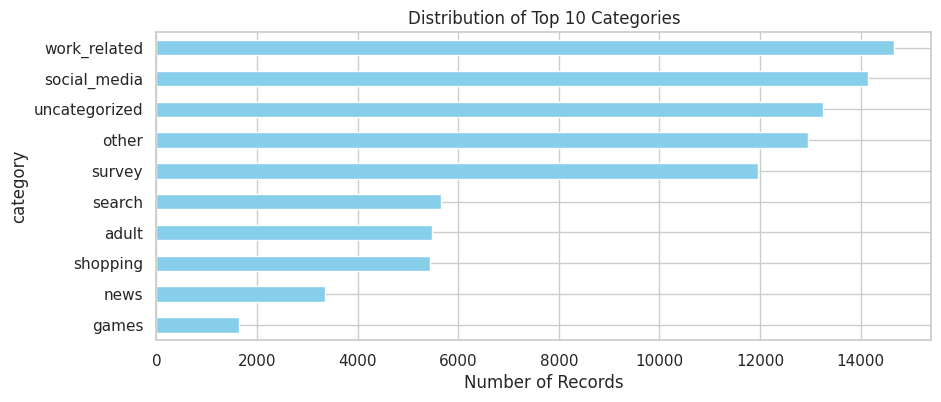

In [9]:
# --- Full Solution ---

# --- STEP 1: TEMPORAL FEATURE EXTRACTION ---
# Extract hour and day name from the timestamp
df_final['hour'] = df_final['used_at'].dt.hour
df_final['day_name'] = df_final['used_at'].dt.day_name()

# --- STEP 2: CATEGORY MAPPING ---
# Perform a left join to enrich the browsing data with website categories
# Both dataframes use 'domain' as the join key
df_final = pd.merge(
    df_final,
    category_df,
    on='domain',
    how='left'
)

# Fill domains not found in the category map with 'uncategorized'
df_final['category'] = df_final['category'].fillna('uncategorized')

# --- STEP 3: DATA VALIDATION (Print Statistics) ---

# 1. Integrity Check: Ensure no users (pids) were lost during the merge
unique_pids = df_final['pid'].nunique()
print(f"Total Unique Users (pid) retained: {unique_pids}")
print(f"Total Records in table: {len(df_final)}")

# 2. Preview the enriched table
print("\n--- Feature Table Preview ---")
# Focus on the relationship between pid, time, and category
display(df_final[['pid', 'used_at', 'hour', 'day_name', 'domain', 'category']].head())

# 3. Categorization Summary
print("\n--- Category Coverage Summary ---")
cat_counts = df_final['category'].value_counts()
print(cat_counts)

# 4. Verification Visualization: Quick check of data distribution
plt.figure(figsize=(10, 4))
cat_counts.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Distribution of Top 10 Categories")
plt.xlabel("Number of Records")
plt.show()

## Part 3: Behavioral Visualization (Digital Fingerprints)

Each user has a unique "digital fingerprint"—a signature of when and how they interact with the web. By visualizing the **7x24 hour rhythm** of a specific user, we can uncover their personal habits (e.g., are they a night owl or a focused morning worker?).

#### 📝 Task 4: The Weekly Rhythm (Heatmap)
We will create a heatmap that shows activity intensity across different hours and days for a **single user**.

> **💡 Analytical Tip:**
> A "Global Heatmap" (all users) often washes out individual traits. Filtering for a specific `pid` allows us to see true human behavior—like consistent late-night browsing on weekends vs. structured work hours on weekdays.

**Requirements:**
1. Pick a specific `pid` (user) from the dataset.
2. Create a pivot table to aggregate their session counts by `day_name` and `hour`.
3. Use `sns.heatmap` to visualize the density.

Analyzing Digital Fingerprint for Top User: 17928019436992


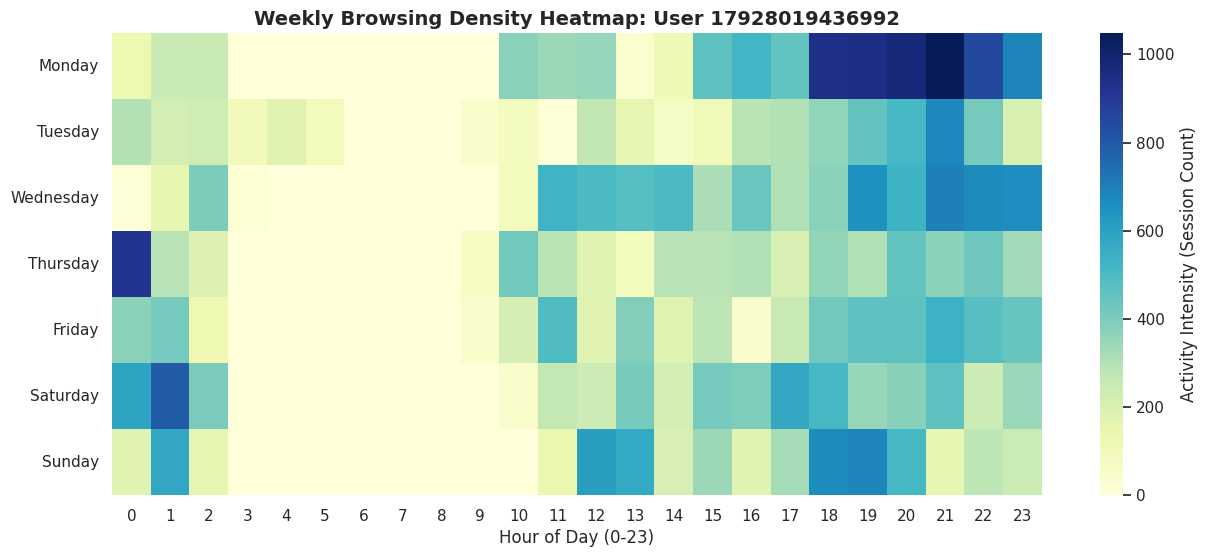

Observation Task: Look at User 17928019436992's heatmap.
- Is there a clear gap during late-night hours (sleeping)?
- Does the activity pattern change on Saturday and Sunday?


In [10]:
# --- Full Solution ---

# Let's find the most active user to ensure we have an interesting heatmap
top_user_id = df_final['pid'].value_counts().idxmax()
print(f"Analyzing Digital Fingerprint for Top User: {top_user_id}")

# --- STEP 2: FILTER & PIVOT ---
# Filter data for this specific user
user_df = df_final[df_final['pid'] == top_user_id].copy()

# Define the order of days for the Y-axis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the pivot table
# Index: Days of the week, Columns: Hours of the day
pivot_table = user_df.pivot_table(
    index='day_name',
    columns='hour',
    values='pid',
    aggfunc='count'
).reindex(days_order)

# Fill NaN values with 0 (hours with no activity)
pivot_table = pivot_table.fillna(0)

# --- STEP 3: VISUALIZE ---
plt.figure(figsize=(15, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    annot=False,  # Set to True if you want to see the actual numbers
    cbar_kws={'label': 'Activity Intensity (Session Count)'}
)

plt.title(f"Weekly Browsing Density Heatmap: User {top_user_id}", fontsize=14, fontweight='bold')
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("")
plt.show()

# --- STEP 4: REFLECTION ---
print(f"Observation Task: Look at User {top_user_id}'s heatmap.")
print("- Is there a clear gap during late-night hours (sleeping)?")
print("- Does the activity pattern change on Saturday and Sunday?")

#### 📝 Task 5: Top Websites (Bar Charts)
Now that we know *when* this user is active, let's see *where* they go. We will identify the most frequently visited domains for the same user.

#### 📝 Task 6: Online Activities Overview (Bubble Chart)
To get a high-level view of this user's interests, we will use a **Bubble Chart**. Unlike a standard bar chart, a bubble chart (using the `circlify` library) represents the frequency of visits per category through the area of a circle, providing a more intuitive sense of "interest density."

> **💡 Analytical Insight:**
> Comparing specific domains (Task 5) with general categories (Task 6) helps us distinguish between a user's **tools** (e.g., Google, GitHub) and their **hobbies** (e.g., Entertainment, Social Media).

Generating behavioral profile for User: 17928019436992


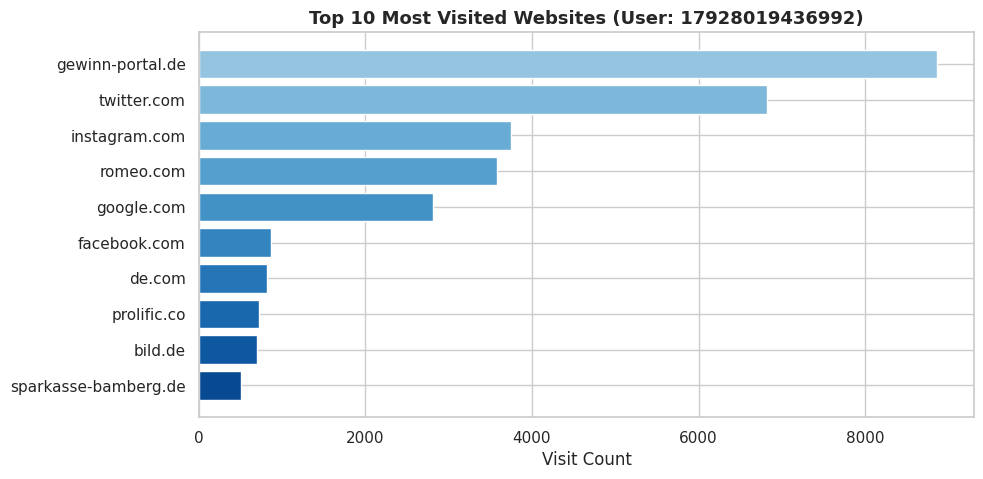

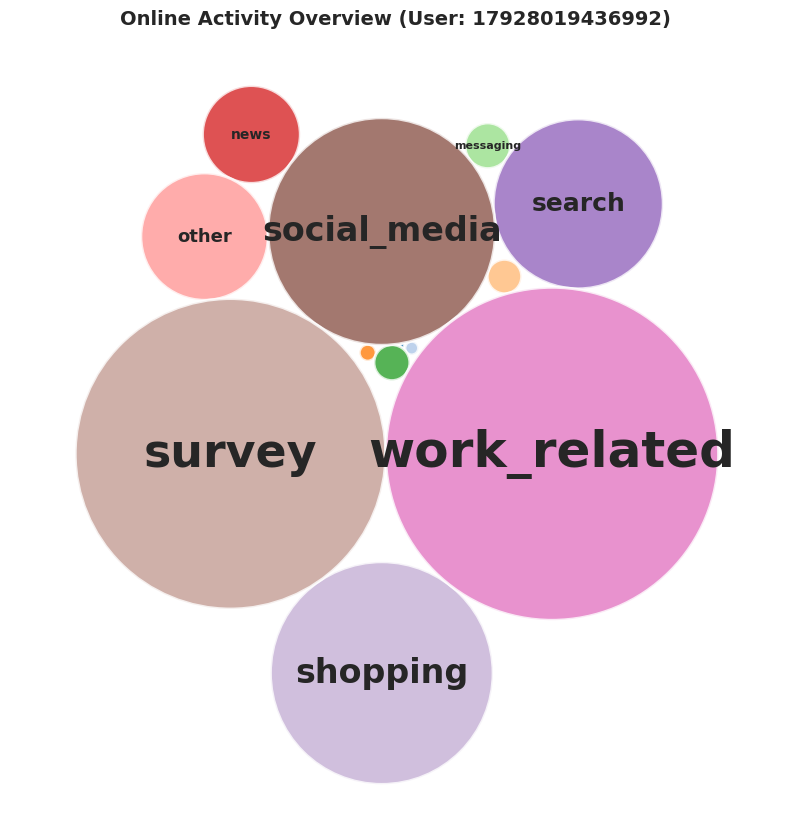

In [11]:

# --- PRE-REQUISITE: Use the same PID for a consistent "Digital Fingerprint" ---
# Pick the most active user as our study subject
target_pid = df_final['pid'].value_counts().idxmax()
user_df = df_final[df_final['pid'] == target_pid].copy()

print(f"Generating behavioral profile for User: {target_pid}")

# --- Task 5: Top Websites (Bar Charts) ---
top_sites = user_df['domain'].value_counts().head(10)

plt.figure(figsize=(10, 5))
# Use a color gradient for professional look
colors = plt.cm.Blues(np.linspace(0.4, 0.9, 10))
plt.barh(top_sites.index, top_sites.values, color=colors)
plt.gca().invert_yaxis() # Highest count on top
plt.title(f"Top 10 Most Visited Websites (User: {target_pid})", fontsize=13, fontweight='bold')
plt.xlabel("Visit Count")
plt.show()

# --- Task 6: Online Activities Overview (Bubble Chart) ---
# Aggregate counts by category, excluding 'uncategorized'
agg = user_df[user_df['category'] != 'uncategorized'].groupby("category")["pid"].count().reset_index(name='count')

if not agg.empty:
    # Compute circle positions using circlify
    circles = circlify.circlify(
        agg['count'].tolist(),
        show_enclosure=False,
        target_enclosure=circlify.Circle(0, 0, 1.0)
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off") # Remove axes for aesthetic look
    ax.set_aspect("equal") # Ensure circles are not distorted

    # --- FIX: Dynamically set limits to prevent bubbles from being cut off ---
    max_r = 0
    for circle in circles:
        # Distance from center + radius
        dist = np.sqrt(circle.x**2 + circle.y**2) + circle.r
        if dist > max_r:
            max_r = dist

    # Add a 5% margin to the boundary
    ax.set_xlim(-max_r * 1.05, max_r * 1.05)
    ax.set_ylim(-max_r * 1.05, max_r * 1.05)

    # Use a distinct color palette
    cmap = plt.get_cmap("tab20")

    for circle, label, i in zip(circles, agg['category'], range(len(agg))):
        x, y, r = circle.x, circle.y, circle.r
        # Loop through cmap if categories > 20
        ax.add_patch(plt.Circle((x, y), r, facecolor=cmap(i % 20), alpha=0.8, edgecolor="white", linewidth=2))

        # Only add labels to bubbles large enough to fit text
        if r > 0.05:
            ax.text(x, y, label, ha="center", va="center",
                    fontsize=max(8, int(r*80)), fontweight="bold")

    plt.title(f"Online Activity Overview (User: {target_pid})", fontsize=14, fontweight='bold')
    plt.show()
else:
    print(f"No categorized data found for User: {target_pid}")

#### 📝 Task 7: Search Intent (Word Cloud)
While categories tell us *what* type of site a user visits, **Search Queries** tell us *exactly* what they are looking for. By extracting query parameters from search engine URLs (like Google or Bing), we can visualize the user's specific interests.

> **💡 Analytical Insight:**
> This visualization completes the "Digital Fingerprint." We now know **when** they browse (Heatmap), **where** they go (Top Domains), **what** they do (Bubble Chart), and finally, **what they think about** (Word Cloud).

**Note**: Since the dataset originates from Germany, we will filter out both English and German "Stop Words" (common words like 'the', 'und', 'der') to ensure only meaningful terms appear.

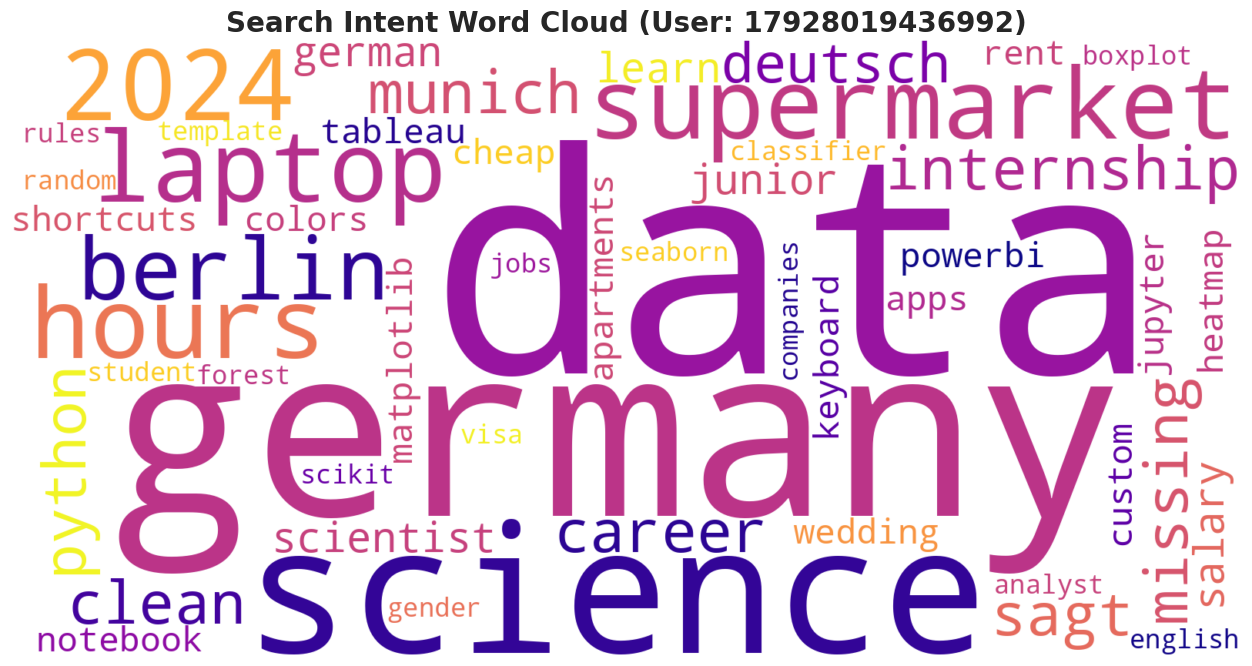

In [12]:

# --- Full Solution ---
def plot_user_wordcloud(df, user_id):
    # Combine English and German stop words to filter out noise
    stop_words = set(get_stop_words("english")) | set(get_stop_words("german"))
    # Add common search-related noise words manually if needed
    # stop_words.update(['google', 'search', 'html', 'index', 'php'])

    # Helper function to extract search terms from URL query parameters
    def extract_search_query(url):
        # Look for 'q=' or 'query=' in the URL string
        match = re.search(r'[?&](q|query)=([^&]+)', str(url))
        if match:
            # Decode URL characters (e.g., %20 to space) and replace '+' with space
            query = unquote(match.group(2)).replace('+', ' ')
            return query
        return ""

    # Filter data for the specific user and extract queries
    user_data = df[df['pid'] == user_id].copy()
    queries = user_data['url'].apply(extract_search_query)

    # Combine all queries into a single string
    all_text = " ".join(queries).lower()

    # Tokenize words: Keep only alphanumeric characters (including German umlauts)
    # Using \wäöüß to support German specific characters
    words = re.findall(r"[\wäöüß]+", all_text)

    # Filter: Remove stop words and very short words (less than 3 chars)
    filtered_words = [w for w in words if w not in stop_words and len(w) >= 3]

    # --- STEP 2: GENERATION ---
    if not filtered_words:
        print(f"No search queries found for User: {user_id}")
        return

    # Count frequencies for better WordCloud control
    word_freq = Counter(filtered_words)

    # Generate the WordCloud object
    # Plasma colormap and high resolution for a professional look
    wc = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        colormap="plasma",
        max_words=100
    ).generate_from_frequencies(word_freq)

    # --- STEP 3: VISUALIZATION ---
    plt.figure(figsize=(16, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off") # Hide axes for the cloud
    plt.title(f"Search Intent Word Cloud (User: {user_id})", fontsize=20, fontweight='bold')
    plt.show()

# Execute the function for our target user
plot_user_wordcloud(df_final, target_pid)

## Part 4: Demographic Perspectives (Market Segmentation)

Data becomes truly powerful when we understand *who* is behind the screen. In this final section, we merge our behavioral features with sociodemographic data (**Age** and **Gender**) to identify group-level trends.

#### 📝 Task 8: Demographic Group Comparison
We will use our **Engineered Features** (like Average Daily Usage and Categories) to answer:
1.  Do different **Age Groups** have different browsing intensities?
2.  How does **Gender** influence the types of content consumed?

> **💡 Analytical Tip:**
> Avoid using raw session counts for comparison, as one "power user" can skew the results. Instead, use **Averages per User** within each demographic group to ensure a fair comparison.

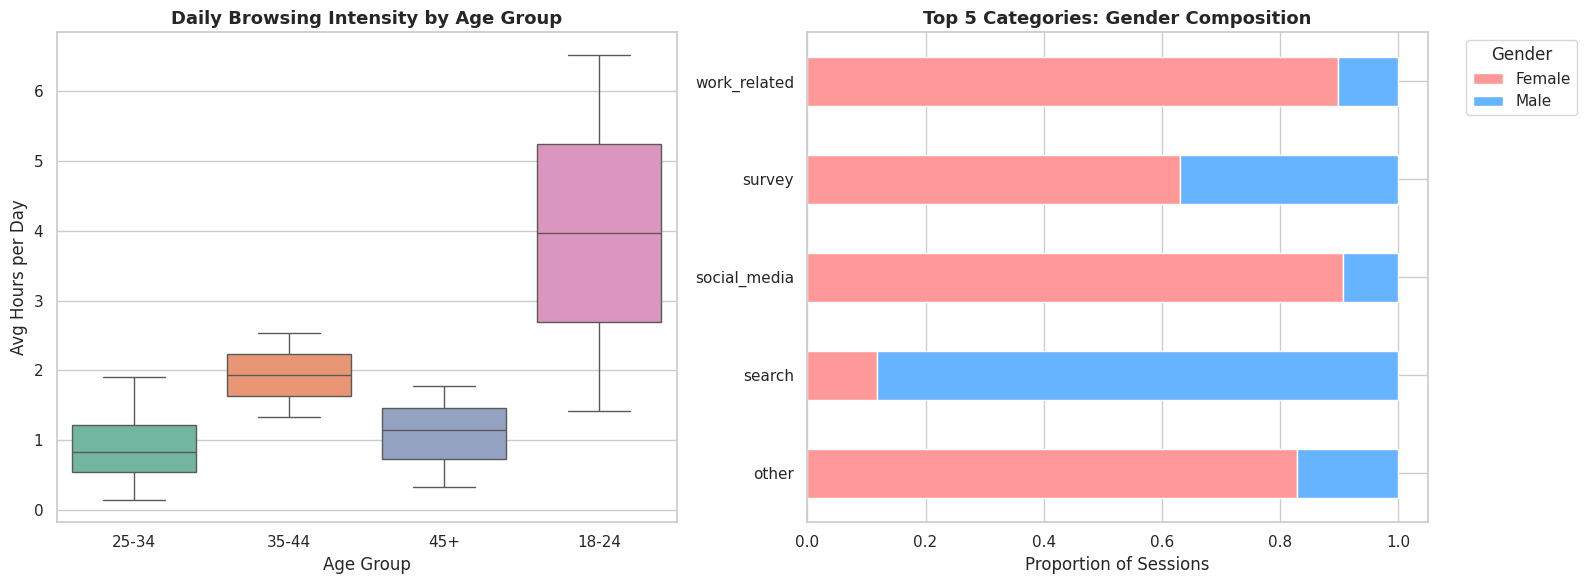

--- Final Demographic Insights ---
Most active age group: 18-24 (3.98 hrs/day)


In [13]:
# --- Full Solution ---
# --- STEP 1: MERGE DEMOGRAPHICS ---
# We merge demo into our feature-rich 'df_final'
df_demographic = pd.merge(df_final, demo_df, on='pid', how='left')

# --- STEP 2: GROUP-LEVEL FEATURE CALCULATION ---
# Calculate Average Daily Intensity per user first
user_intensity = df_demographic.groupby(['pid', 'age_group', 'gender', 'date'])['duration'].sum() / 3600
avg_user_intensity = user_intensity.groupby(['pid', 'age_group', 'gender']).mean().reset_index(name='avg_hours')

# --- STEP 3: VISUALIZATION ---
plt.figure(figsize=(16, 6))

# Subplot 1: Age Group vs. Browsing Intensity
plt.subplot(1, 2, 1)
sns.boxplot(data=avg_user_intensity, x='age_group', y='avg_hours', hue='age_group', palette='Set2', legend=False)
plt.title("Daily Browsing Intensity by Age Group", fontsize=13, fontweight='bold')
plt.ylabel("Avg Hours per Day")
plt.xlabel("Age Group")

# Subplot 2: Gender & Category Preferences
# We look at the top 5 categories (excluding uncategorized) across genders
top_cats = df_demographic[df_demographic['category'] != 'uncategorized']['category'].value_counts().head(5).index
df_top_cats = df_demographic[df_demographic['category'].isin(top_cats)]

plt.subplot(1, 2, 2)
# Calculate percentage of sessions per category by gender
cat_gender_dist = df_top_cats.groupby(['gender', 'category']).size().unstack(level=0)
cat_gender_dist_pct = cat_gender_dist.div(cat_gender_dist.sum(axis=1), axis=0)

cat_gender_dist_pct.plot(kind='barh', stacked=True, ax=plt.gca(), color=['#ff9999','#66b3ff'])
plt.title("Top 5 Categories: Gender Composition", fontsize=13, fontweight='bold')
plt.xlabel("Proportion of Sessions")
plt.ylabel("")
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- STEP 4: FINAL SUMMARY ---
overall_age_avg = avg_user_intensity.groupby('age_group')['avg_hours'].mean()
print("--- Final Demographic Insights ---")
print(f"Most active age group: {overall_age_avg.idxmax()} ({overall_age_avg.max():.2f} hrs/day)")

## Part 5: Bonus Challenge – Your Own Digital Reflection

Do you want to see your own "Digital Fingerprint"? You can apply today's entire pipeline to your personal browsing history!

#### How to do it at home:
1. **Export your history**:
   * Use the Chrome extension ([Export Chrome History](https://chromewebstore.google.com/detail/export-chrome-history/dihloblpkeiddiaojbagoecedbfpifdj?hl=en)).
   * It will generate a CSV file containing columns like `date`, `time`, `url`, and `visitCount`.
2. **Align the data**:
   * Upload your CSV to this notebook.
   * Simply rename your columns to match our `df_final` structure.
3. **Run the visualizations**:
   * Re-run these functions using your data.
